https://github.com/shivaverma/Clock-Reader/blob/master/clock.ipynb

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
root_directory = "images/*"
files = []

In [3]:
for f in glob.glob(root_directory):
    if os.path.isfile(f):
        files.append(os.path.basename(f))

In [4]:
files[:10]

['130_original_130.JPG_1f5e490c-6b8d-4143-9c31-4e9cfa581c68.JPG',
 '102_original_102.JPG_4103c399-8ac7-4c1d-94b3-fc2167fee6fb.JPG',
 '80_original_80.JPG_2386a9c7-de5c-493b-96d7-88c4829973ec.JPG',
 '88_original_88.JPG_72779462-31a8-4d68-a784-4715f5fddb57.JPG',
 '69_original_69.JPG_fe001ef1-d61d-4024-b8f5-e73fb541ee19.JPG',
 '158_original_158.JPG_c5f2c60a-9df6-47fa-aada-1518e21a679e.JPG',
 '155_original_155.JPG_ac399bdd-d820-4b15-b2e3-617a232b9edf.JPG',
 '100_original_100.JPG_7b54cde2-f770-43d9-92fe-24507ab733f5.JPG',
 '105_original_105.JPG_2ed954d1-947a-47c9-afad-a3a698e2b331.JPG',
 '92_original_92.JPG_77707a29-1545-49a1-b08c-d78dfa4632ed.JPG']

In [5]:
len(files)

32000

In [6]:
data = pd.DataFrame()
data["file_basename"] = files
# data["file_no_extension"] = data.apply(lambda x: x["file_basename"].split('.')[0], axis=1)
# data["file_id"] = data.apply(lambda x: os.path.splitext(str(x["file_basename"].split('-')[1]))[0], axis=1)
data["target"] = data.apply(lambda x: x["file_basename"].split('_')[0], axis=1)

data["target"] = data["target"].astype(int)

data.head(100)

# data.iloc[0]

,file_basename,target
0,130_original_130.JPG_1f5e490c-6b8d-4143-9c31-4...,130
1,102_original_102.JPG_4103c399-8ac7-4c1d-94b3-f...,102
2,80_original_80.JPG_2386a9c7-de5c-493b-96d7-88c...,80
3,88_original_88.JPG_72779462-31a8-4d68-a784-471...,88
4,69_original_69.JPG_fe001ef1-d61d-4024-b8f5-e73...,69
...,...,...
95,110_original_110.JPG_2ef64b2a-4ab7-4a12-8742-e...,110
96,130_original_130.JPG_1ea62f17-a057-4e21-ac83-5...,130
97,80_original_80.JPG_3ad64f37-3d03-44e4-a61a-600...,80
98,152_original_152.JPG_9322a216-8dda-4af9-8528-a...,152


In [14]:
def preprocess(im):
    im = im/255
    im -= .5
    return im

In [10]:
channel = 1
im_width = 100
im_height = 100
path = 'images/'

In [14]:
# Loading the images
X = []
for img in data["file_basename"]:
    # import pdb; pdb.set_trace();
    im = Image.open(path + img).convert('L')
    im = im.resize((im_width,im_height), Image.ANTIALIAS)
    im = np.array(im)
    # X.append(preprocess(im).reshape((im_size, im_size, channel)))
    kk = preprocess(im).reshape((im_width, im_height, channel))
    X.append(np.array(kk))
    # print("HI")

X2 = np.asarray(X)

In [15]:
# train_ids = np.arange(1500) # num of pictures

# x_train, y1_train, y2_train = load_image_batch(train_ids)

X_train, X_test, y_train, y_test = train_test_split(X2, (data["target"]-54)/106, test_size=0.3, random_state=42)

In [16]:
inp = Input(shape=(im_width,im_height, channel))

x = Conv2D(50, kernel_size=5, strides=2, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = BatchNormalization()(x)

x = Conv2D(100, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(150, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(200, kernel_size=3, strides=1, activation='relu')(x)
x = Dropout(.4)(x)

x = Flatten()(x)

#hour = Dense(144, activation='relu')(x)
#hour = Dense(144, activation='relu')(hour)
#hour = Dense(12, activation='softmax', name='hour')(hour)

radio_slider = Dense(100, activation='relu')(x)
radio_slider = Dense(200, activation='relu')(radio_slider)
radio_slider = Dense(1, activation='linear', name='radio_slider')(radio_slider)

# model = Model(inputs=inp, outputs=[hour, minute])
model = Model(inputs=inp, outputs=radio_slider)

# model.summary()

In [17]:
adam = tf.keras.optimizers.Nadam(lr=.00001)
# model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer=adam, metrics=['accuracy', 'mae'])
model.compile(loss=['mse'], optimizer=adam, metrics=['mae'])

In [18]:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# patient early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [19]:
# history = model.fit(X_train, [y_train], epochs=100, batch_size=32, callbacks=[es, mc])
history = model.fit(X_train, [y_train], epochs=250, batch_size=32, callbacks=[es])

Train on 22400 samples
Epoch 1/250
22400/22400 [==============================] - 78s 3ms/sample - loss: 0.1017 - mae: 0.2551
Epoch 2/250
22400/22400 [==============================] - 77s 3ms/sample - loss: 0.0639 - mae: 0.1997
Epoch 3/250
22400/22400 [==============================] - 77s 3ms/sample - loss: 0.0521 - mae: 0.1771
Epoch 4/250
22400/22400 [==============================] - 83s 4ms/sample - loss: 0.0439 - mae: 0.1604
Epoch 5/250
22400/22400 [==============================] - 75s 3ms/sample - loss: 0.0386 - mae: 0.1486
Epoch 6/250
22400/22400 [==============================] - 75s 3ms/sample - loss: 0.0336 - mae: 0.1376
Epoch 7/250
22400/22400 [==============================] - 76s 3ms/sample - loss: 0.0301 - mae: 0.1286
Epoch 8/250
22400/22400 [==============================] - 76s 3ms/sample - loss: 0.0267 - mae: 0.1205
Epoch 9/250
22400/22400 [==============================] - 75s 3ms/sample - loss: 0.0239 - mae: 0.1136
Epoch 10/250
22400/22400 [========================

In [20]:
# saved_model = load_model('best_model.h5')
model.save("model.h5")
saved_model = load_model('model.h5')

In [21]:
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.025, Test: 0.026


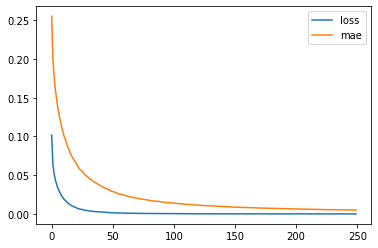

In [22]:
# plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='mae')
plt.legend()
plt.show()

## Testing

In [7]:
saved_model = load_model('model.h5')

In [8]:
samples_path = "samples/"

def predict(ind):
                    
    im = Image.open(samples_path + str(ind) + '.jpg')
    plt.imshow(im, cmap='gray')
    print('Input image:')
    plt.show()
    im = im.convert('L')
    im = im.resize((im_width,im_height), Image.ANTIALIAS)
    im = np.array(im)
    im = preprocess(im).reshape((1, im_width, im_height, channel))

    predicted_val = saved_model.predict(im)
    
    # hour = np.argmax(time[0])
    # minute = int(time[1][0][0]*5)
    # print('Detected value:', str(minute))
    # print(int(time[0][0]*106+54))
    print(int(predicted_val[0][0]*106+54))

Input image:


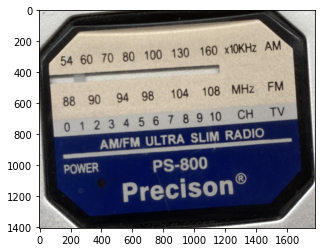

57
Input image:


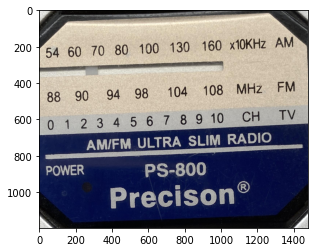

64
Input image:


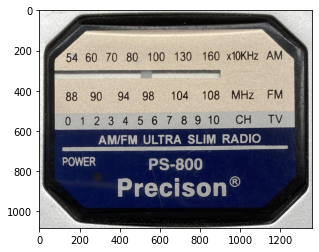

90
Input image:


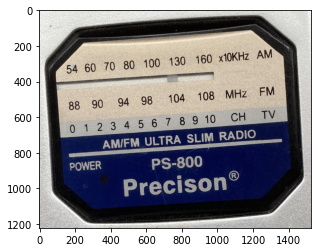

119
Input image:


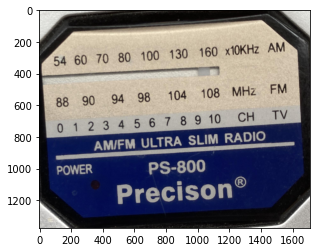

144
Input image:


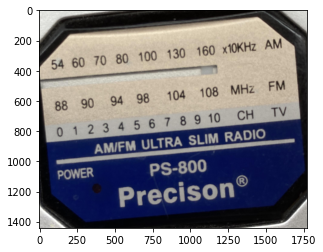

149
#########
Input image:


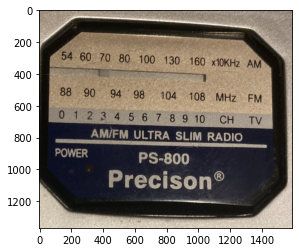

93
Input image:


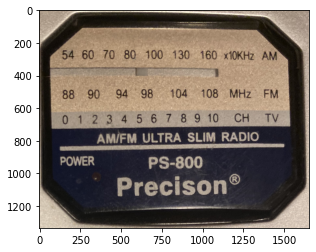

84
Input image:


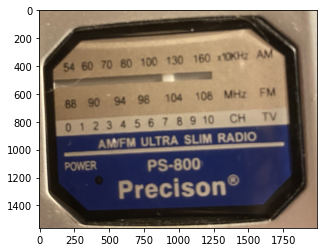

79
Input image:


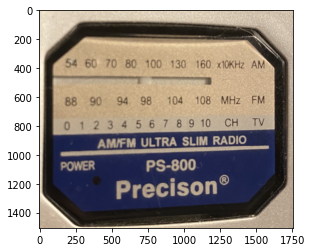

83


In [17]:
predict("54-4")
predict("65-11")
predict("90-8")
predict("120-5")
predict("155-4")
predict("160-6")
###
print("#########")
predict('IMG_1202_cut')
predict('IMG_1203_cut')
predict('IMG_1204_cut')
predict('IMG_1205_cut')


## Testing on the test set from train test split

In [25]:
len(X_test)

9600

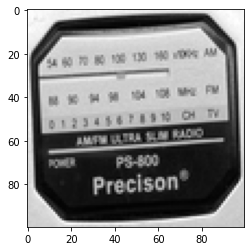

101
-----------------


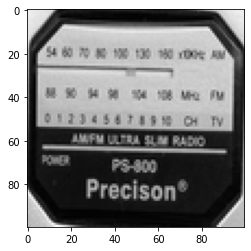

109
-----------------


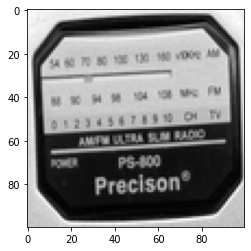

70
-----------------


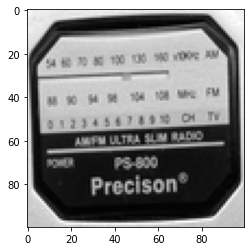

107
-----------------


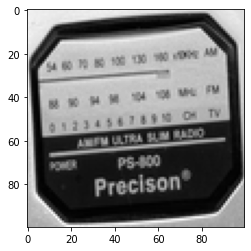

148
-----------------


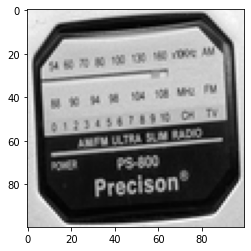

141
-----------------


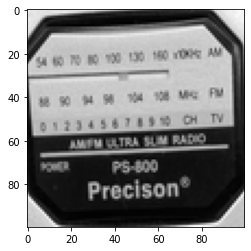

107
-----------------


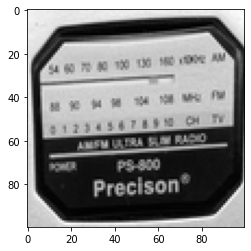

136
-----------------


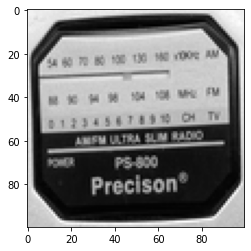

107
-----------------


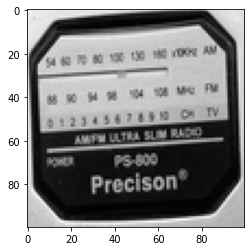

104
-----------------


In [31]:
for i in random.sample(list(X_test), 10):
    pruebame = i.reshape(1,im_width,im_height,1)
    time = saved_model.predict(pruebame)


    please = np.squeeze((i*255).astype(int))

    plt.imshow(please, cmap='gist_gray')
    plt.show()
    print(int(time*106+54))
    print("-----------------")